# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 8
# Ensemble methods

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave


Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [3]:
data_train = pd.read_csv('Higgs_train.csv')
data_test = pd.read_csv('Higgs_test.csv')

In [4]:
X_train = data_train.iloc[:, data_train.columns != ' class']
y_train = data_train[' class']
X_test = data_test.iloc[:, data_test.columns != ' class']
y_test = data_test[' class']

In [5]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5000, 28) (5000,) (5000, 28) (5000,)


# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between a collision that produces Higgs bosons and collisions thats produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle colision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.


## Question 1 (2pt): Single Decision Tree
We start by building a basic model which we will use as our base model for comparison. 

1. Fit a decision tree model to the training set and report the classification accuracy of the model on the test set. Use 5-fold cross-validation to choose the (maximum) depth for the tree. You will use the max_depth you find here throughout the homework. 


In [6]:
parameters = {'max_depth':range(2,10)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv=5, n_jobs=4)
'clf.fit(X_train, y_train.flatten(y_train.tolist())'
clf.fit(X_train, y_train)
tree_model = clf.best_estimator_
print ('The classifier had the best CrossValidated score of:', clf.best_score_)
print('at a depth of:', clf.best_params_)
md = 5
print ('The classifier had a Train score of:', tree_model.score(X_train,y_train))
print ('The classifier had a Test score of:', tree_model.score(X_test,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,tree_model.predict(X_test)))


The classifier had the best CrossValidated score of: 0.6386
at a depth of: {'max_depth': 5}
The classifier had a Train score of: 0.682
The classifier had a Test score of: 0.6456
The confusion matrix is:
[[1530  822]
 [ 950 1698]]


## Question 2 (15pt): Dropout-based Approach
We start with a simple method inspired from the idea of 'dropout' in machine learning, where we fit multiple decision trees on random subsets of predictors, and combine them through a majority vote. The procedure is described below.

- For each predictor in the training sample, set the predictor values to 0 with probability $p$  (i.e. drop the predictor by setting it to 0). Repeat this for $B$ trials to create $B$ separate training sets.


- Fit decision tree models $\hat{h}^1(x), \ldots, \hat{h}^B(x) \in \{0,1\}$ to the $B$ training sets. You may allow the trees to have unrestricted depth.

- Combine the decision tree models into a single classifier by taking a majority vote:
$$
\hat{H}_{maj}(x) \,=\, majority\Big(\hat{h}^1(x), \ldots, \hat{h}^B(x)\Big).
$$


We shall refer to the combined classifier as an ** *ensemble classifier* **. Implement the described dropout approach, and answer the following questions:
1. Apply the dropout procedure with $p = 0.5$ for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracy of the combined classifier. Does an increase in the number of trees improve the training and test performance? Explain your observations in terms of the bias-variance trade-off for the classifier.
- Fix the number of trees to 64 and apply the dropout procedure with different dropout rates $p = 0.1, 0.3, 0.5, 0.7, 0.9$. Based on your results, explain how the dropout rate influences the bias and variance of the combined classifier.
- Apply 5-fold cross-validation to choose the optimal combination of the dropout rate and number of trees. How does the test performance of an ensemble of trees fitted with the optimal dropout rate and number of trees compare with the single decision tree model in Question 1?
[hint: Training with large number of trees can take long time. You may need to restrict the max number of trees.]

1. The training accuracy on this model stayed at a constant 1. for all n number of trees, though the test accuracy grew as n grew. This can be understood in the context of bias v variance as follows: As the number of n trees increases the variance is reduced without negatively affecting bias.
2. The model with the best testing performance was that with p=.5. This aligns with the idea that there is some optimal value p where the model is neither overfit nor underfit. If we were to increase the number of predictors in the model, thus increasing its complexity, we would reduce bias at the expense of variance. If we were to reduce the number of predictors, we would see an increase in bias and decrease it variance. This optimal value p=.5 should be where the toal error from bias and variance is minimized.


In [7]:
def dropout_function_forest(B, p, md=None):
    stat_list=[]
    test_counts = np.zeros((y_test.shape[0], B))
    train_counts = np.zeros((y_train.shape[0], B))
    for i in range(B):
        train_set = X_train.copy()
        for column in train_set.columns:
            if np.random.uniform() < p:
                train_set[column] = 0
        test_counts[:,i] = (DecisionTreeClassifier(max_depth=md).fit(train_set, y_train)).predict(X_test)
        train_counts[:,i] = (DecisionTreeClassifier(max_depth=md).fit(train_set, y_train)).predict(X_train)
       

    y_hat = (np.mean(test_counts,
                     axis=1)>.5).astype(float)
    y_hat_train = (np.mean(train_counts,axis=1)>.5).astype(float)
    test_acc = metrics.accuracy_score(y_test, y_hat)
    train_acc = metrics.accuracy_score(y_train, y_hat_train)
    test_scores.append(test_acc)
    train_scores.append(train_acc)
    print("Dropout rate:", p, "Number of trees:", B, "Test Accuracy:", test_acc, "Train Accuracy:", train_acc )
    stat_list = [B, test_acc, train_acc]
    return stat_list

Dropout rate: 0.5 Number of trees: 2 Test Accuracy: 0.5884 Train Accuracy: 1.0
Dropout rate: 0.5 Number of trees: 4 Test Accuracy: 0.5658 Train Accuracy: 1.0
Dropout rate: 0.5 Number of trees: 8 Test Accuracy: 0.6234 Train Accuracy: 1.0
Dropout rate: 0.5 Number of trees: 16 Test Accuracy: 0.6386 Train Accuracy: 1.0
Dropout rate: 0.5 Number of trees: 32 Test Accuracy: 0.6652 Train Accuracy: 1.0
Dropout rate: 0.5 Number of trees: 64 Test Accuracy: 0.6744 Train Accuracy: 1.0
Dropout rate: 0.5 Number of trees: 128 Test Accuracy: 0.682 Train Accuracy: 1.0
Dropout rate: 0.5 Number of trees: 256 Test Accuracy: 0.6844 Train Accuracy: 1.0


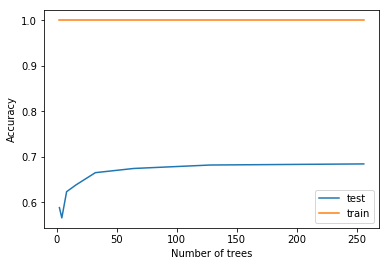

In [8]:
train_scores = []
test_scores = []
number_trees = [2,4,8,16,32,64,128,256]
for number in number_trees:
    dropout_function_forest(number, 0.5)


plt.plot(number_trees, test_scores, label='test')
plt.plot(number_trees, train_scores, label='train')
plt.legend(loc='best')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.show()

Dropout rate: 0.1 Number of trees: 64 Test Accuracy: 0.63 Train Accuracy: 1.0
Dropout rate: 0.3 Number of trees: 64 Test Accuracy: 0.6646 Train Accuracy: 1.0
Dropout rate: 0.5 Number of trees: 64 Test Accuracy: 0.6756 Train Accuracy: 1.0
Dropout rate: 0.7 Number of trees: 64 Test Accuracy: 0.6492 Train Accuracy: 1.0
Dropout rate: 0.9 Number of trees: 64 Test Accuracy: 0.5748 Train Accuracy: 1.0


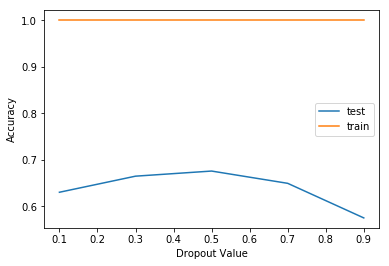

In [9]:
train_scores = []
test_scores = []
ps = [0.1,0.3,0.5,0.7,0.9]
for p in ps:
    dropout_function_forest(64, p)
    
plt.plot(ps, test_scores, label='test')
plt.plot(ps, train_scores, label='train')
plt.legend(loc='best')
plt.xlabel('Dropout Value')
plt.ylabel('Accuracy')
plt.show()

In [10]:
Q2.3 is incomplete. need cross val performed



SyntaxError: invalid syntax (<ipython-input-10-daeaa6830164>, line 1)

## Question 3 (15pt): Random Forests

We now move to a more sophisticated ensemble technique, namely random forest:
1. How does a random forest approach differ from the dropout procedure described in Question 2? 
 
- Fit random forest models to the training set for different number of trees (say $2, 4, 8, 16, \ldots, 256$), and evaluate the training and test accuracies of the models. You may set the number of predictors for each tree in the random forest model to $\sqrt{p}$, where $p$ is the total number of predictors. 

- Based on your results, do you find that a larger number of trees necessarily improves the test accuracy of a random forest model? Explain how the number of trees effects the training and test accuracy of a random forest classifier, and how this relates to the bias-variance trade-off for the classifier. 
  
- Fixing the number of trees to a reasonable value, apply 5-fold cross-validation to choose the optimal value for the  number of predictors. How does the test performance of random forest model fitted with the optimal number of trees compare with the dropout approach in Question 2?  





1. Rather than creating trees from resampled data, the dropout procedure just uses differnt sets of predictors. Random forests also use a subset of predictors, but uses resampled training data to grow each tree, thus lowering variance.
2. The training and test accuracies on this model followed a similar patter. Both test and train accuracies grew quickly as n number of trees grew, until around 32 trees where the growth slowed dramatically. See graph below.
3. As the number of trees grew test and train accuracy continues to increase although at a much slower rate for n>32. Since the trees are grown from resampled data, additional trees continue to reduce variance while not increasing bias. We see continue gains in accuracy on both test and train as the resampling controls overfitting.
4. Using CV, we find that an optimal model where max featues=11, has a test score a few points higher than the droput model above. 

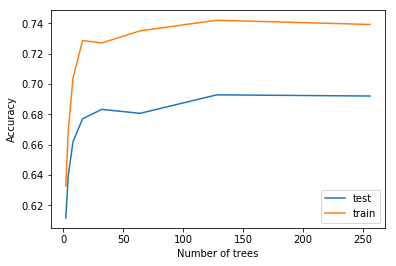

In [11]:
train_scores = []
test_scores = []
trees = [2,4,8,16,32,64,128,256]

for tree in trees:
    rf = RandomForestClassifier(n_estimators=tree, max_depth=md, max_features='sqrt')
    rf.fit(X_train, y_train)
    test_scores.append(rf.score(X_test,y_test))
    train_scores.append(rf.score(X_train,y_train))
plt.plot(number_trees, test_scores, label='test')
plt.plot(number_trees, train_scores, label='train')
plt.legend(loc='best')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.show()

In [12]:
rf_64 = RandomForestClassifier(n_estimators=64, max_depth=md)

p_dict = {'max_features' : np.arange(1,28,1) }
clf = GridSearchCV(rf_64, p_dict , cv=5, n_jobs=4)
clf.fit(X_train, y_train)
rf_64_best = clf.best_estimator_
rf_64_best_params = clf.best_params_ 
print('The number of predictors p=', rf_64_best_params, 'had the highest cross validation score of :', clf.best_score_ )

The number of predictors p= {'max_features': 11} had the highest cross validation score of : 0.6802


In [13]:

print ('The classifier had a Train score of:', rf_64_best.score(X_train,y_train))
print ('The classifier had a Test score of:', rf_64_best.score(X_test,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,rf_64_best.predict(X_test)))

The classifier had a Train score of: 0.7316
The classifier had a Test score of: 0.6964
The confusion matrix is:
[[1556  796]
 [ 722 1926]]


## Question 4 (15pt): Boosting

We next compare the random forest model with the approach of boosting:


1. Apply the AdaBoost algorithm to fit an ensemble of decision trees. Set the learning rate to 0.05, and try out different tree depths for the base learners: 1, 2, 10, and unrestricted depth.  Make a plot of the training accuracy of the ensemble classifier as a function of tree depths. Make a similar plot of the test accuracies as a function of number of trees (say $2, 4, 8, 16, \ldots, 256$).
- How does the number of trees influence the training and test performance? Compare and contrast between the trends you see in the training and test performance of AdaBoost and that of the random forest models in Question 3. Give an explanation for your observations.
- How does the tree depth of the base learner impact the training and test performance? Recall that with random forests, we allow the depth of the individual trees to be unrestricted. Would you recommend the same strategy for boosting? Explain your answer.
- Apply 5-fold cross-validation to choose the optimal number of trees $B$ for the ensemble and the optimal tree depth for the base learners. How does an ensemble classifier fitted with the optimal number of trees and the optimal tree depth compare with the random forest model fitted in Question 3.4? 



1. See code below
2. Our training score climb as our number of trees increases, but our testing scores almost remain constant. For the deeper models, the train scores reached 1 alomost immeadiately. In the random forest we reduced variance, where here, we reduce bias through adaboosting. The models that were less complex, with lower n trees, increased in training accuracy much slower as each additional tree reduced further bias.
3. It seems that where depth is unrestricted or high, train scores are much higher, but test scores are a bit below lower depth models. Here deeper, complex decision trees overfit the data. Would not recommend greater depths, since we are not employing any resampling to reduce the variance and control overfitting.
4. The optimal depth=2 with n=256 trees, had a testing acc of 68.5%. This is slightly lower than the random forest model from above.

In [15]:
# code adapted from section 9
accuracies_train = []
accuracies_test = []
trees = [2**x for x in range(9)]
for md in [1,2,10,None]:
    depth_accuracies_train = []
    depth_accuracies_test = []
    for n in trees:
        ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=md),n_estimators=n, learning_rate=.05)
        depth_accuracies_train.append(metrics.accuracy_score(y_train, ada.fit(X_train,y_train).predict(X_train)))
        depth_accuracies_test.append(metrics.accuracy_score(y_test, ada.fit(X_train,y_train).predict(X_test)))
    accuracies_train.append(depth_accuracies_train)
    accuracies_test.append(depth_accuracies_test)



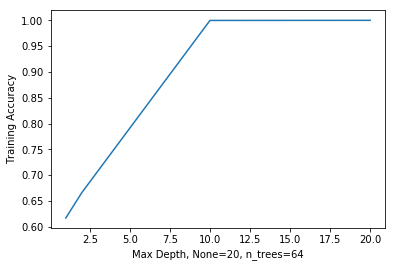

In [16]:
i=0
mds=[]
accs=[]
for md in (1,2,10,20):
    mds.append(md)
    accs.append(accuracies_train[i][5])
    plt.xlabel('Max Depth, None=20, n_trees=64')
    plt.ylabel('Training Accuracy')
    i=i+1
plt.plot(mds,accs)

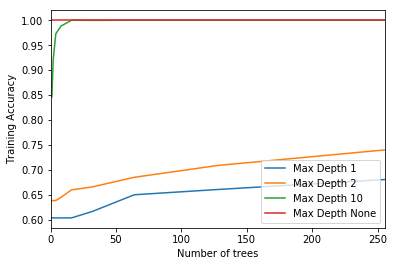

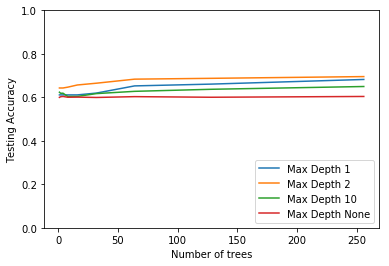

In [17]:
for i, md in enumerate([1,2,10,None]):
    plt.plot(trees, accuracies_train[i], label='Max Depth {}'.format(md))
plt.legend(loc=4)
plt.xlabel('Number of trees')
plt.ylabel('Training Accuracy')

plt.xlim(0, 256)
plt.show()

for i, md in enumerate([1,2,10,None]):
    plt.plot(trees, accuracies_test[i], label='Max Depth {}'.format(md))
plt.legend(loc=4)
plt.ylim(0, 1)
plt.xlabel('Number of trees')
plt.ylabel('Testing Accuracy')
plt.show()

In [18]:
depths = [1,2,10,None]
ada_2=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=md),n_estimators=n, learning_rate=.05)

params = {'base_estimator__max_depth' : depths, 'n_estimators': trees }
clf = GridSearchCV(ada_2, params , cv=5, n_jobs=4)
clf.fit(X_train, y_train)
ada_2_best = clf.best_estimator_
ada_2_best_params = clf.best_params_ 
print('Based on the highest cross validation score of :', clf.best_score_ )
print('The best parameters are:', ada_2_best_params)

Based on the highest cross validation score of : 0.685
The best parameters are: {'base_estimator__max_depth': 2, 'n_estimators': 256}


In [ ]:
print ('The boosted classifier had a Train score of:', ada_2_best.score(X_train,y_train))
print ('The boosted classifier had a Test score of:', ada_2_best.score(X_test,y_test))
print('The confusion matrix is:')
print(confusion_matrix(y_test,ada_2_best.predict(X_test)))




## Question 5 (3pt): Meta-classifier

We have so far explored techniques that grow a collection of trees either by creating multiple copies of the original training set, or through a sequential procedure, and then combines these trees into a single classifier. Consider an alternate scenario where you are provided with a pre-trained collection of trees, say from different participants of a data science competition for Higgs boson discovery. What would be a good strategy to combine these pre-fitted trees into a single powerful classifier? Of course, a simple approach would be to take the majority vote from the individual trees. Can we do better than this simple combination strategy?

A collection of 100 decision tree classifiers is provided in the file `models.npy` and can be loaded into an array by executing:

`models = np.load('models.npy')`

You can make predictions using the $i^\text{th}$ model on an array of predictors `x` by executing:

`model[i].predict(x)`  &nbsp;&nbsp;&nbsp;
or &nbsp;&nbsp;&nbsp;
`model[i].predict_proba(x)`

and score the model on predictors `x` and labels `y` by using:

`model[i].score(x, y)`.

1. Implement a strategy to combine the provided decision tree classifiers, and compare the test perfomance of your approach with the majority vote classifier. Explain your strategy/algorithm.



In [110]:
models

array([ DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       DecisionTreeClassifier(class_wei

In [109]:
models = np.load('models.npy', encoding='latin1')
predictions = []

for i in range(1,100):
    prediction = model[i].predict_proba(x)
    predictions.append(prediction)
avg_prediction
    

--- 

---

## APCOMP209a - Homework Question
​
We've worked with imputation methods on missing data in Homework 6.  We've worked with Decision Trees in HW7 and here.  Now let's see what happens if we try to work with Decision Trees and Missing Data at the same time! We'll be working with a dataset from the UCI Machine Learning Repository that uses a variety of wine chemical predictors to classify wines grown in the same region in Italy.  Each line represents 13 (mostly chemical) predictors of the response variable wine class, including things like alcohol content, hue , and phenols.  Unfortunately some of the predictor values were lost in measurement. Please load `wine_quality_missing.csv`. 
​
*Note*: As in HW6 be careful of reading/treating column names and row names in this data set.
​
​
1. Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the sklearn DecisionTreeClassifier and RandomForestClassifier.   Use cross-validation to find the optimal tree depth for each method.  Report the optimal tree-depth, overall classification rate and confusion matrix on the test set for each method.
2. Restart with a fresh copy of the data and impute the missing data via mean imputation.  Split the data 75-25 and again fit DecisionTreeClassifier and RandomForestClassifier using cross-validation to find the optimal tree depth.  Report the optimal tree depth, overall classification rate and confusion matrix on the test set for each method.  
3. Again restart with a fresh copy of the data but this time let's try something different.  As discussed in section, CART Decision Trees can take advantage of surrogate splits to handle missing data.  Split the data 75-25 and construct a **custom** decision tree model and train it on the training set with missing data. Report the optimal tree depth, overall classification rate and confusion matrix on the test set and compare your results to the Imputation and DecisionTree model results in part 1 & 2.
